3.2:
    1) Load the CT imagedataset, define paths to the datasets, including the path to COVID and Non-COVID data.
    2) Split DataFrame into train, test DataFrames using the function train_test_split(test_size=0.2) from the sklearn.model_selection library.
    3) Add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function
    4) Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE. and EPOCHS.
    5) Create a data generator class for reading in DICOM images or use the class provided. This custom data generator class creates a train and validation generator.
    6) Import a pre-trained VGG16 model from Keras for training with hyperparameters.
    7) Train model, change hyperparameters, for example train test split proportion, batch size, vary a number of training epochs, and display variations in results.
    8) After training finishes, plot training and validation accuracy and losses vs. epochs. 
    9) Save the model in .h5 format.
    10) Load trained model and do predictions on 10 CT images.

(1)

In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


,image_path,target
0,/media/ricardo/hd1/Ricardo/uca/COVID-CT-master...,1
1,/media/ricardo/hd1/Ricardo/uca/COVID-CT-master...,1
2,/media/ricardo/hd1/Ricardo/uca/COVID-CT-master...,1
3,/media/ricardo/hd1/Ricardo/uca/COVID-CT-master...,1
4,/media/ricardo/hd1/Ricardo/uca/COVID-CT-master...,1


In [12]:

csv_file = '/content/drive/My Drive/Colab Notebooks/data/ct_dicom.csv'

df = pd.read_csv(csv_file, dtype=str)
df.head()

,image_path,target
0,/content/drive/My Drive/Colab Notebooks/data/D...,1
1,/content/drive/My Drive/Colab Notebooks/data/D...,1
2,/content/drive/My Drive/Colab Notebooks/data/D...,1
3,/content/drive/My Drive/Colab Notebooks/data/D...,1
4,/content/drive/My Drive/Colab Notebooks/data/D...,1


(2)

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [3]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 8.3MB/s 


(3)

In [21]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

# tested on tf 2.1 

class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
              
        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array
    
      
# read data
# Assuming it has two cols:
# image_path: path to each image with its extension
# target: labels (here it is 0s and 1s) -> binary classification
#done!
#df = pd.read_csv("yourDfPath.csv", dtype=str)

# split for testing
# done!
#train_df, test_df = train_test_split(df, test_size=0.2)

# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 100
SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=valid_augmenter,
                             **valid_consts)


Found 348 validated image filenames belonging to 2 classes.
Found 87 validated image filenames belonging to 2 classes.


(1)(f)

In [15]:
from keras.applications.vgg16 import VGG16
 
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
from keras.layers import Dense, Flatten
from keras.models import Model
 
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = Flatten()(last_output)
x = Dense(2, activation='softmax', name='softmax')(x)

In [18]:
new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:

from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
opt = Adam(learning_rate=0.00001)
new_model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
# training
history = new_model.fit_generator(
	generator=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=EPOCHS,
	validation_data=valid_generator,
	validation_steps=len(valid_generator)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
11/11 [==============================] - 79s 8s/step - loss: 4.7216 - accuracy: 0.6263 - val_loss: 2.8051 - val_accuracy: 0.7816
Epoch 2/100
11/11 [==============================] - 5s 488ms/step - loss: 4.2999 - accuracy: 0.6527 - val_loss: 2.3456 - val_accuracy: 0.7471
Epoch 3/100
11/11 [==============================] - 5s 473ms/step - loss: 4.3292 - accuracy: 0.6726 - val_loss: 2.4446 - val_accuracy: 0.7701
Epoch 4/100
11/11 [==============================] - 5s 480ms/step - loss: 3.5872 - accuracy: 0.6810 - val_loss: 2.1489 - val_accuracy: 0.8161
Epoch 5/100
11/11 [==============================] - 5s 478ms/step - loss: 3.8654 - accuracy: 0.6367 - val_loss: 2.7372 - val_accuracy: 0.7816
Epoch 6/100
11/11 [==============================] - 5s 477ms/step - loss: 3.4106 - accuracy: 0.7171 - val_loss: 2.4935 - val_accuracy: 0.8161
Epoch 7/100
11/11 [==============================] - 5s 474ms/step - loss: 3.7670 - accuracy: 0.6570 - val_loss: 2.0839 - val_accuracy: 0.8161
E

(2)(e)

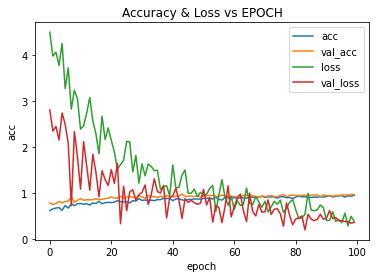

In [24]:
import matplotlib.pyplot as plot
plot.plot(history.history["accuracy"])
plot.plot(history.history['val_accuracy'])
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title("Accuracy & Loss vs EPOCH")
plot.ylabel("acc")
plot.xlabel("epoch")
plot.legend(["acc","val_acc","loss","val_loss"])
plot.show()

In [ ]:
(2)(f)

In [26]:
# Using the testing generator to evaluate the model after training
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=test_augmenter,
                             **test_consts)
test_loss, test_accuracy = new_model.evaluate(test_generator, steps=len(test_generator))

Found 109 validated image filenames belonging to 2 classes.
109/109 [==============================] - 47s 430ms/step - loss: 1.6179 - accuracy: 0.8532


Prediction: 
Normal1.0


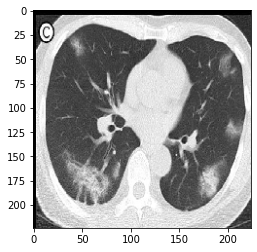

In [28]:
x, y = test_generator.next()
run = new_model.predict(np.expand_dims(x[0], axis=0))[0]
print("Prediction: ")

if run[0] > run[1]:
    print("Covid " + str(run[0]))
else:
    print("Normal" + str(run[1]))

plot.imshow(x[0])